In [22]:
# Imports and Setup
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation, RandomCrop, ColorJitter
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import timm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

In [ ]:
# === Directories ===
dataset_dir = "C:/Users/arfao/Desktop/imp_4c_dataset/dataset"
MODEL_DIR = "C:/Users/arfao/Desktop/imp_4c_dataset/models"
RESULTS_DIR = "C:/Users/arfao/Desktop/imp_4c_dataset/results"
CLASS_NAMES = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
BATCH_SIZE = 32
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.30
NUM_WORKERS = 8

# Ensure directories exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
#
def load_data():
    try:
        # Define transforms (no augmentation for training)
        train_transforms = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        val_transforms = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load dataset
        full_dataset = ImageFolder(dataset_dir, transform=train_transforms)
        dataset_size = len(full_dataset)
        train_size = int(0.80 * dataset_size)  # Explicit 70/30 split
        val_size = dataset_size - train_size  # Remaining 30%

        # Split dataset
        train_dataset, val_dataset = random_split(
            full_dataset, [train_size, val_size]
        )
        val_dataset.dataset.transform = val_transforms

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

        print(f"Dataset sizes: Train={train_size}, Val={val_size}")
        return train_loader, val_loader, full_dataset
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

In [25]:
import matplotlib.pyplot as plt
import os

CLASS_NAMES = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]

def plot_class_distribution(dataset):
    try:
        # Initialize counts for four classes
        class_counts = [0] * len(CLASS_NAMES)  # [0, 0, 0, 0]
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#4f30b7']  # Four colors
        
        # Check if labels are strings or integers
        unique_labels = set(label for _, label in dataset)
        print("Unique labels in dataset:", unique_labels)
        
        # If labels are strings, map them to indices
        if any(isinstance(label, str) for label in unique_labels):
            label_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
            for _, label in dataset:
                class_counts[label_to_index[label]] += 1
        else:
            # Assume integer labels; adjust if not 0-based
            min_label = min(unique_labels)
            if min_label != 0:
                for _, label in dataset:
                    class_counts[label - min_label] += 1
            else:
                for _, label in dataset:
                    class_counts[label] += 1
        
        # Plotting
        plt.figure(figsize=(10, 7.5))
        plt.bar(CLASS_NAMES, class_counts, color=colors)
        plt.title('Class Distribution in Dataset')
        plt.xlabel('Class')
        plt.ylabel('Number of Images')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        max_count = max(class_counts)
        plt.ylim(0, max_count * 1.2)
        for i, count in enumerate(class_counts):
            plt.text(i, count + 20, str(count), ha='center', va='bottom')
        save_path = os.path.join(RESULTS_DIR, 'class_distribution.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved class distribution plot to {save_path}")
    except Exception as e:
        print(f"Error plotting class distribution: {e}")
        raise

# Example usage (ensure RESULTS_DIR and full_dataset are defined)
# RESULTS_DIR = "path/to/results"
# plot_class_distribution(full_dataset)

In [26]:

def plot_sample_images(dataset, class_names, num_samples=4):
    try:
        plt.figure(figsize=(15, 5))
        class_samples = {name: [] for name in class_names}
        for img, label in dataset:
            class_name = class_names[label]
            if len(class_samples[class_name]) < num_samples:
                class_samples[class_name].append(img)
            if all(len(samples) >= num_samples for samples in class_samples.values()):
                break
        for i, class_name in enumerate(class_names):
            for j, img in enumerate(class_samples[class_name]):
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = img.permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)
                plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
                plt.imshow(img)
                plt.title(f'{class_name}')
                plt.axis('off')
        plt.tight_layout()
        save_path = os.path.join(RESULTS_DIR, 'sample_images.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved sample images plot to {save_path}")
    except Exception as e:
        print(f"Error plotting sample images: {e}")
        raise


In [27]:

def plot_confidence_histogram(all_probs, all_labels):
    try:
        all_probs = np.vstack(all_probs)
        max_probs = np.max(all_probs, axis=1)
        plt.figure(figsize=(8, 6))
        plt.hist(max_probs, bins=20, color='skyblue', edgecolor='black')
        plt.title('Confidence Score Histogram')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        save_path = os.path.join(RESULTS_DIR, 'confidence_histogram.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved confidence histogram to {save_path}")
    except Exception as e:
        print(f"Error plotting confidence histogram: {e}")
        raise


In [28]:
def plot_accuracy(train_acc, val_acc):
    try:
        epochs = range(1, len(train_acc) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
        plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
        plt.title('Train vs Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        save_path = os.path.join(RESULTS_DIR, 'accuracy_plot.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved accuracy plot to {save_path}")
    except Exception as e:
        print(f"Error plotting accuracy: {e}")

In [29]:

def plot_loss(train_loss, val_loss):
    try:
        epochs = range(1, len(train_loss) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_loss, label='Train Loss', marker='o')
        plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
        plt.title('Train vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        save_path = os.path.join(RESULTS_DIR, 'loss_plot.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved loss plot to {save_path}")
    except Exception as e:
        print(f"Error plotting loss: {e}")
        raise


In [30]:

# def plot_confusion_matrix(all_labels, all_probs):
#     try:
#         all_preds = np.argmax(np.vstack(all_probs), axis=1)
#         cm = confusion_matrix(all_labels, all_preds)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
#         plt.title('Confusion Matrix')
#         plt.xlabel('Predicted')
#         plt.ylabel('True')
#         save_path = os.path.join(RESULTS_DIR, 'confusion_matrix.png')
#         plt.savefig(save_path)
#         plt.show()
#         plt.close()
#         print(f"Saved confusion matrix to {save_path}")
#     except Exception as e:
#         print(f"Error plotting confusion matrix: {e}")
#         raise

def plot_confusion_matrix(all_labels, all_preds):  # Changed parameter from all_probs to all_preds
    try:
        cm = confusion_matrix(all_labels, all_preds)  # Use all_preds directly
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        save_path = os.path.join(RESULTS_DIR, 'confusion_matrix.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved confusion matrix to {save_path}")
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")
        raise




In [31]:

def plot_roc_curve(all_labels, all_probs):
    try:
        all_probs = np.vstack(all_probs)
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(CLASS_NAMES):
            fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        save_path = os.path.join(RESULTS_DIR, 'roc_curve.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved ROC curve to {save_path}")
    except Exception as e:
        print(f"Error plotting ROC curve: {e}")
        raise


In [32]:
def random_masking(images, num_segments=8, mask_ratio=0.5):
    B = images.size(0)
    mask = torch.rand(B, num_segments, device=images.device) < mask_ratio
    return mask


class IJEPA(nn.Module):
    def __init__(self, model_name='tf_efficientnetv2_b0', embed_dim=1280):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.projector = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Dropout(0.3)  # Dropout in projector
        )
        self.predictor = nn.Sequential(
            nn.Dropout(0.6),  # Increased dropout
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.num_segments = 8  # Updated from 4 to 8

    def forward(self, x, mask):
        x = self.backbone(x)
        x = self.projector(x)
        target = x.detach()
        pred = self.predictor(x)
        B, D = pred.shape

        segment_size = D // self.num_segments
        assert D % self.num_segments == 0, "embed_dim must be divisible by num_segments"

        pred = pred.view(B, self.num_segments, segment_size)
        target = target.view(B, self.num_segments, segment_size)

        mask = mask.unsqueeze(-1).expand(-1, -1, segment_size)
        masked_pred = pred[mask].reshape(-1, segment_size)
        masked_target = target[mask].reshape(-1, segment_size)

        return masked_pred, masked_target

cosine_loss = lambda x, y: 1 - F.cosine_similarity(x, y, dim=-1).mean()


In [33]:
def train_ijepa(model, optimizer, scheduler, loader, val_loader, epochs=15, mask_ratio=0.5, patience=3):
    best_val = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, _ in tqdm(loader, desc=f"Epoch {epoch+1} JEPA"):
            images = images.to(next(model.parameters()).device)
            mask = random_masking(images, num_segments=model.num_segments, mask_ratio=mask_ratio)
            pred, target = model(images, mask)
            loss = cosine_loss(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(next(model.parameters()).device)
                mask = random_masking(images, num_segments=model.num_segments, mask_ratio=mask_ratio)
                pred, target = model(images, mask)
                val_loss += cosine_loss(pred, target).item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Check for improvement
        if avg_val_loss < best_val:
            best_val = avg_val_loss
            save_path = os.path.join(MODEL_DIR, "best_ijepa.pth")
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved model to {save_path}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

        scheduler.step(avg_val_loss)

    # Save training history
    history = {'train_loss': train_losses, 'val_loss': val_losses}
    history_path = os.path.join(MODEL_DIR, 'history_ijepa.pth')
    torch.save(history, history_path)
    print(f"📝 Saved history to {history_path}")

    return train_losses, val_losses, best_val


In [34]:
def train_classifier(model, optimizer, criterion, train_loader, val_loader, scheduler, epochs=15, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_val_acc = 0.0
    train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []
    patience_counter = 0

    for epoch in range(epochs):
        # Training loop
        model.train()
        correct = total = train_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Classifier"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total
        train_loss_avg = train_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss_avg)

        # Validation loop
        model.eval()
        correct = total = val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
            val_acc = correct / total
            val_loss_avg = val_loss / len(val_loader)
            val_accuracies.append(val_acc)
            val_losses.append(val_loss_avg)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss_avg:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss_avg:.4f}, Val Acc = {val_acc:.4f}")

        # Early stopping and saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = os.path.join(MODEL_DIR, "best_classifier.pth")
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved model to {save_path}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1}")
                break
        scheduler.step(val_acc)

    # Collect predictions after training
    all_labels, all_preds, all_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Save training history
    history = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    history_path = os.path.join(MODEL_DIR, 'history_classifier.pth')
    torch.save(history, history_path)
    print(f"💾 Saved history to {history_path}")

    return train_accuracies, val_accuracies, train_losses, val_losses, all_labels, all_preds, all_probs

In [35]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, input, output):
            self.activations = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)  # updated for newer PyTorch

    def generate(self, input_image, target_class=None):
        self.model.eval()
        input_image = input_image.requires_grad_(True)
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[:, target_class].backward()
        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # shape: [B, C, 1, 1]
        cam = torch.sum(weights * activations, dim=1)  # shape: [B, H, W]
        cam = F.relu(cam)
        cam = cam - cam.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        cam = cam / (cam.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] + 1e-10)
        return cam.detach().cpu(), target_class


In [36]:
def visualize_gradcam(model, val_loader, class_names, num_images=5):
    try:
        print("Starting Grad-CAM visualization")
        target_layer = model.blocks[-1]  # Adjust this to your model
        grad_cam = GradCAM(model, target_layer)

        images, labels = next(iter(val_loader))
        num_images = min(num_images, images.size(0))

        for i in range(num_images):
            img = images[i:i+1]
            label = labels[i].item()
            cam, predicted_class = grad_cam.generate(img)
            cam = cam[0]  # get single CAM: shape [H, W]

            # Denormalize image
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_denorm = img[0].cpu() * std + mean
            img_denorm = img_denorm.permute(1, 2, 0).numpy()
            img_denorm = np.clip(img_denorm, 0, 1)
            h, w, _ = img_denorm.shape

            # Resize CAM to original image dimensions
            cam_resized = cv2.resize(cam.numpy(), (w, h))
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            heatmap = heatmap[..., ::-1]  # BGR to RGB

            overlay = heatmap * 0.4 + img_denorm * 0.6
            overlay = np.clip(overlay, 0, 1)

            # Plot
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(img_denorm)
            plt.title(f'Original Image\nTrue: {class_names[label]}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(cam_resized, cmap='jet')
            plt.title('Grad-CAM Heatmap')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(overlay)
            plt.title(f'Overlay\nPredicted: {class_names[predicted_class]}')
            plt.axis('off')

            plt.tight_layout()
            save_path = os.path.join(RESULTS_DIR, f'gradcam_image_{i+1}.png')
            plt.savefig(save_path)
            plt.show()
            plt.close()
            print(f"Saved Grad-CAM visualization to {save_path}")
    except Exception as e:
        print(f"Error in Grad-CAM visualization: {e}")
        raise


In [37]:


# Cell 1: Load Data
train_loader, val_loader, full_dataset = load_data()


Dataset sizes: Train=9600, Val=2400


Unique labels in dataset: {0, 1, 2, 3}


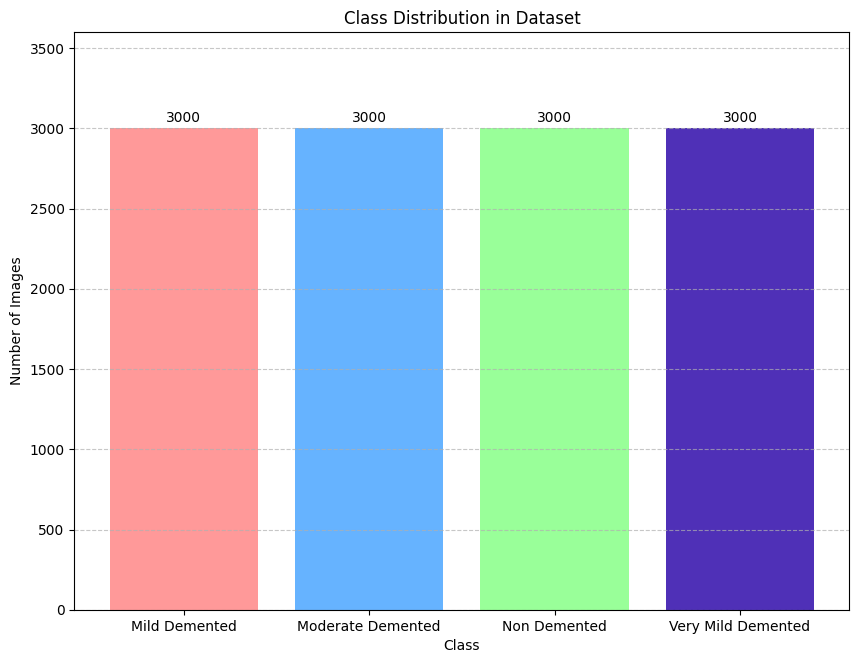

Saved class distribution plot to C:/Users/arfao/Desktop/imp_4c_dataset/results\class_distribution.png


In [38]:

# Cell 2: Plot Class Distribution
plot_class_distribution(full_dataset)


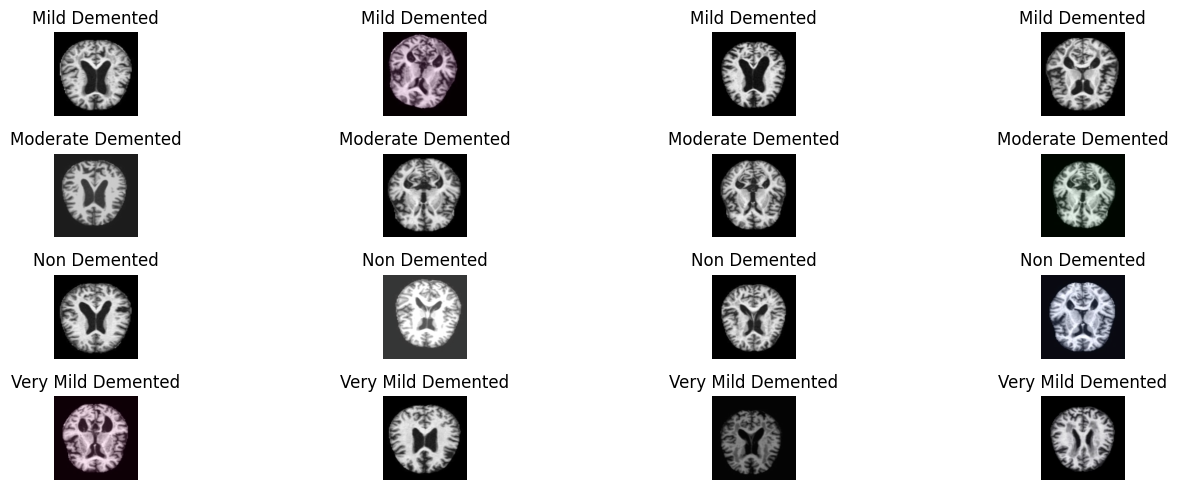

Saved sample images plot to C:/Users/arfao/Desktop/imp_4c_dataset/results\sample_images.png


In [39]:

# Cell 3: Plot Sample Images
plot_sample_images(full_dataset, CLASS_NAMES)


In [40]:
# Cell 4: Train I-JEPA
try:
    print("Starting I-JEPA training")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ijepa_model = IJEPA().to(device)
    optimizer = torch.optim.Adam(ijepa_model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    train_losses, val_losses, best_val = train_ijepa(ijepa_model, optimizer, scheduler, train_loader, val_loader)
    print("Completed I-JEPA training")
except Exception as e:
    print(f"Error in I-JEPA training: {e}")
    raise

Starting I-JEPA training


Epoch 1 JEPA: 100%|██████████| 300/300 [05:51<00:00,  1.17s/it]


Epoch 1: Train Loss = 0.3529, Val Loss = 0.0939
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_ijepa.pth


Epoch 2 JEPA: 100%|██████████| 300/300 [06:17<00:00,  1.26s/it]


Epoch 2: Train Loss = 0.2699, Val Loss = 0.1293


Epoch 3 JEPA: 100%|██████████| 300/300 [06:22<00:00,  1.28s/it]


Epoch 3: Train Loss = 0.2576, Val Loss = 0.1161


Epoch 4 JEPA: 100%|██████████| 300/300 [06:22<00:00,  1.27s/it]


Epoch 4: Train Loss = 0.2615, Val Loss = 0.0987
⏹️ Early stopping at epoch 4
📝 Saved history to C:/Users/arfao/Desktop/imp_4c_dataset/models\history_ijepa.pth
Completed I-JEPA training


In [42]:
try:
    print("Starting classifier training")
    classifier = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=len(CLASS_NAMES))
    
    # Freeze all layers initially
    for param in classifier.parameters():
        param.requires_grad = False
    
    # Unfreeze the last two blocks and classifier head
    for param in classifier.blocks[-2:].parameters():
        param.requires_grad = True
    for param in classifier.classifier.parameters():
        param.requires_grad = True
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    train_accuracies, val_accuracies, train_losses, val_losses, all_labels, all_preds, all_probs = train_classifier(
        classifier, optimizer, criterion, train_loader, val_loader, scheduler
    )
    print("Completed classifier training")
except Exception as e:
    print(f"Error in classifier training: {e}")
    raise

Starting classifier training


Epoch 1 Classifier: 100%|██████████| 300/300 [04:04<00:00,  1.23it/s]


Epoch 1: Train Loss = 0.6548, Train Acc = 0.7451, Val Loss = 0.3454, Val Acc = 0.8579
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_classifier.pth


Epoch 2 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 2: Train Loss = 0.1641, Train Acc = 0.9360, Val Loss = 0.2656, Val Acc = 0.8958
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_classifier.pth


Epoch 3 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 3: Train Loss = 0.0561, Train Acc = 0.9801, Val Loss = 0.2250, Val Acc = 0.9267
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_classifier.pth


Epoch 4 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 4: Train Loss = 0.0513, Train Acc = 0.9826, Val Loss = 0.2332, Val Acc = 0.9167


Epoch 5 Classifier: 100%|██████████| 300/300 [04:06<00:00,  1.21it/s]


Epoch 5: Train Loss = 0.0557, Train Acc = 0.9815, Val Loss = 0.1988, Val Acc = 0.9308
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_classifier.pth


Epoch 6 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 6: Train Loss = 0.0410, Train Acc = 0.9859, Val Loss = 0.1920, Val Acc = 0.9387
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_classifier.pth


Epoch 7 Classifier: 100%|██████████| 300/300 [04:04<00:00,  1.23it/s]


Epoch 7: Train Loss = 0.0317, Train Acc = 0.9892, Val Loss = 0.1523, Val Acc = 0.9508
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_classifier.pth


Epoch 8 Classifier: 100%|██████████| 300/300 [04:07<00:00,  1.21it/s]


Epoch 8: Train Loss = 0.0335, Train Acc = 0.9879, Val Loss = 0.1977, Val Acc = 0.9379


Epoch 9 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 9: Train Loss = 0.0507, Train Acc = 0.9823, Val Loss = 0.2325, Val Acc = 0.9221


Epoch 10 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 10: Train Loss = 0.0368, Train Acc = 0.9874, Val Loss = 0.1832, Val Acc = 0.9450


Epoch 11 Classifier: 100%|██████████| 300/300 [04:04<00:00,  1.22it/s]


Epoch 11: Train Loss = 0.0241, Train Acc = 0.9923, Val Loss = 0.1327, Val Acc = 0.9571
✅ Saved model to C:/Users/arfao/Desktop/imp_4c_dataset/models\best_classifier.pth


Epoch 12 Classifier: 100%|██████████| 300/300 [04:04<00:00,  1.23it/s]


Epoch 12: Train Loss = 0.0240, Train Acc = 0.9929, Val Loss = 0.1728, Val Acc = 0.9529


Epoch 13 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 13: Train Loss = 0.0345, Train Acc = 0.9890, Val Loss = 0.2173, Val Acc = 0.9287


Epoch 14 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 14: Train Loss = 0.0367, Train Acc = 0.9875, Val Loss = 0.1739, Val Acc = 0.9437


Epoch 15 Classifier: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Epoch 15: Train Loss = 0.0380, Train Acc = 0.9861, Val Loss = 0.2038, Val Acc = 0.9421
💾 Saved history to C:/Users/arfao/Desktop/imp_4c_dataset/models\history_classifier.pth
Completed classifier training


In [43]:
# Cell 6: Classification Report
try:
    print("Generating classification report")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
except Exception as e:
    print(f"Error generating classification report: {e}")
    raise

Generating classification report
                    precision    recall  f1-score   support

     Mild Demented       0.94      0.98      0.96       577
 Moderate Demented       1.00      1.00      1.00       590
      Non Demented       0.96      0.85      0.90       610
Very Mild Demented       0.87      0.94      0.91       623

          accuracy                           0.94      2400
         macro avg       0.95      0.94      0.94      2400
      weighted avg       0.94      0.94      0.94      2400



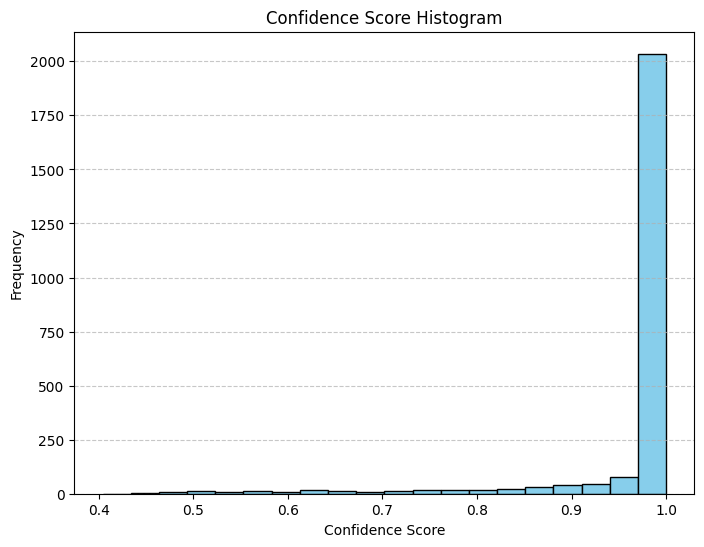

Saved confidence histogram to C:/Users/arfao/Desktop/imp_4c_dataset/results\confidence_histogram.png


In [44]:

# Cell 7: Plot Confidence Histogram
plot_confidence_histogram(all_probs, all_labels)


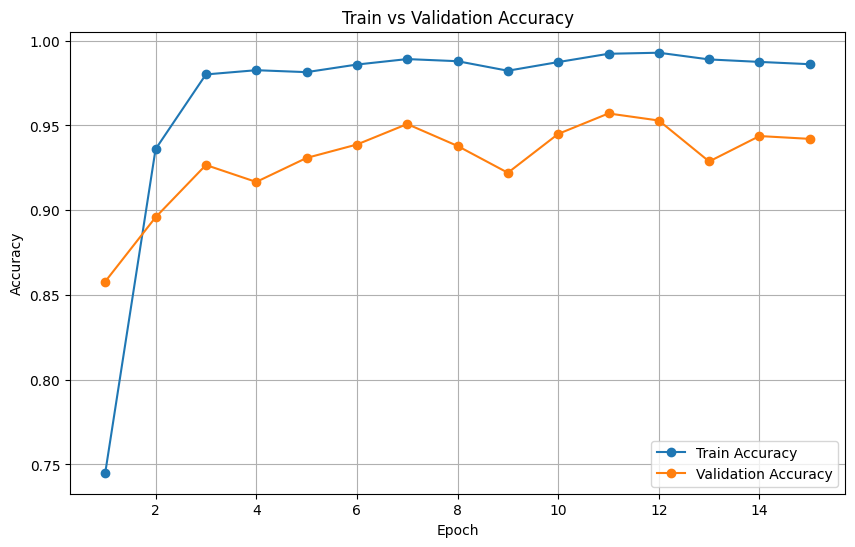

Saved accuracy plot to C:/Users/arfao/Desktop/imp_4c_dataset/results\accuracy_plot.png


In [45]:

# Cell 8: Plot Accuracy
plot_accuracy(train_accuracies, val_accuracies)

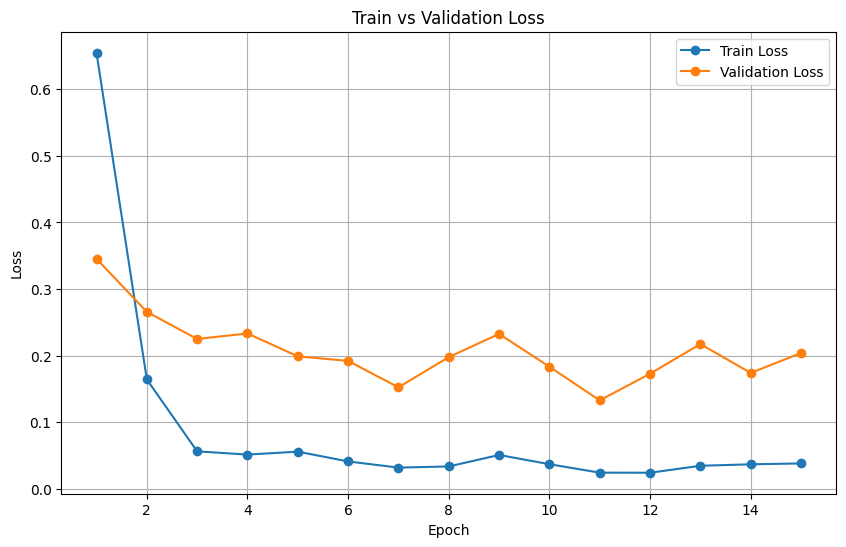

Saved loss plot to C:/Users/arfao/Desktop/imp_4c_dataset/results\loss_plot.png


In [46]:
# Cell 9: Plot Loss
plot_loss(train_losses, val_losses)

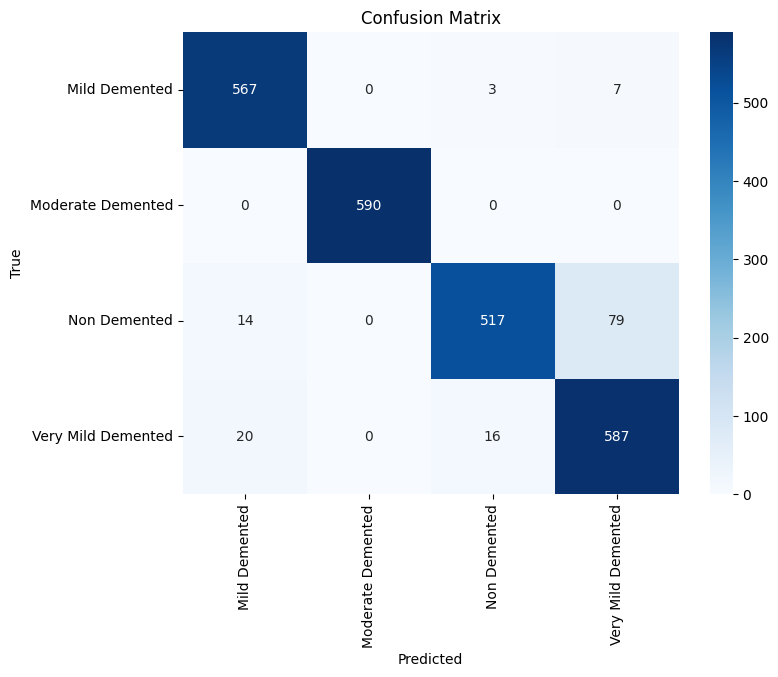

Saved confusion matrix to C:/Users/arfao/Desktop/imp_4c_dataset/results\confusion_matrix.png


In [47]:
# Cell 10: Plot Confusion Matrix

plot_confusion_matrix(all_labels, all_preds)  # Updated call

#plot_confusion_matrix(all_labels, all_probs)

In [48]:
def plot_roc_curve(all_labels, all_probs):
    try:
        all_labels = np.array(all_labels)  # Convert list to NumPy array
        all_probs = np.vstack(all_probs)   # Shape: (n_samples, n_classes)
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(CLASS_NAMES):
            fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        save_path = os.path.join(RESULTS_DIR, 'roc_curve.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        print(f"Saved ROC curve to {save_path}")
    except Exception as e:
        print(f"Error plotting ROC curve: {e}")
        raise

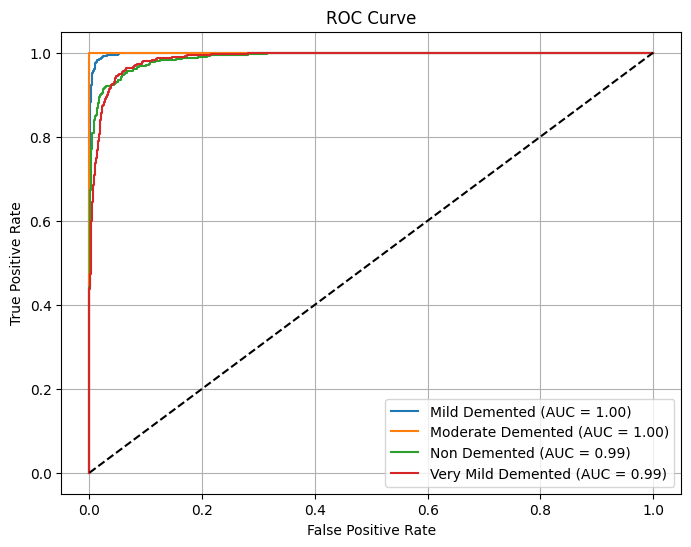

Saved ROC curve to C:/Users/arfao/Desktop/imp_4c_dataset/results\roc_curve.png


In [49]:
# Cell 11: Plot ROC Curve
plot_roc_curve(all_labels, all_probs)